# Primer Paquete de Datos


In [2]:
print("c")

c


In [3]:
print("hola")

hola


In [65]:
# sistema de archivos
import os
# funciones aleatorias
import random
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
from torchvision import transforms
from torchvision.ops import Permute
import torchvision.models as tvm
#redes
from torch.utils.data import DataLoader, random_split
# inspección de arquitectura
from torchsummary import summary
import matplotlib.pyplot as plt
# imágenes
from skimage import io
from skimage.transform import resize
from PIL import Image
from itertools import islice as take
import pandas as pd
from itertools import islice as take

from tqdm.auto import trange
from tqdm.auto import tqdm
import time

## Utilidades

In [6]:
# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8

# tamaño del conjunto de entrenamiento (porcentaje)
TRN_SIZE = 0.8
NUM_WORKERS = 4 # hilos

# media y varianza de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
  """Displays examples in a grid."""
  fig, ax = plt.subplots(rows, cols, figsize=figsize)
  i = 0
  for r in range(rows):
      for c in range(cols):
          ax[r, c].imshow(xs[i], cmap='gray')
          ax[r, c].set_title(titles[i])
          ax[r, c].set_xticklabels([])
          ax[r, c].set_yticklabels([])
          i += 1
  fig.tight_layout()
  plt.show()

def display_batch(x, titles, rows, cols, figsize=(12, 6)):
  """Despliega un lote en una cuadrícula."""
  # denormalizamos
  for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
      x[:, c] = x[:, c] * std + mean 
  x *= 255
  # rotamos canales
  x = x.permute(0, 2, 3, 1)
  # convertimos a entero
  x = (x.numpy()).astype(np.uint8)
  # desplegamos lote
  display_grid(x, titles, rows, cols, figsize)

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def display_losses(losses):
  train_loss, test_loss = zip(*losses)
  plt.plot(train_loss,label='Entrenamiento')
  plt.plot(test_loss,label='Prueba')
  plt.xlabel('Época')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.grid()
  plt.show()
def display_acc(accs):
  train_acc, test_acc = zip(*accs)
  plt.plot(train_acc,label='Entrenamiento')
  plt.plot(test_acc,label='Prueba')
  plt.xlabel('Época')
  plt.ylabel('Precisión')
  plt.legend()
  plt.grid()
  plt.show()

def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


## Creación de los datasets

### Dividir el conjunto en 80% para entrenamiento y 20% para el test

In [7]:
data_dir= "ReduccionSinAumento"
images_names= os.listdir(data_dir)
print(len(images_names))
random.shuffle(images_names)
trn_names= [images_names[i::int(len(images_names))] for i in range(int(len(images_names)*0.8))]
tst_names= [images_names[i::int(len(images_names))] for i in range(int(len(images_names)*0.8), int(len(images_names)))]
print(len(trn_names))
print(len(tst_names))

1606
1284
322


In [8]:
trn_names = [item for items in trn_names for item in items]
tst_names = [item for items in tst_names for item in items]
tsfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
tst_tsfm = transforms.Compose([
    # convertimos a torch.Tensor
    transforms.ToTensor(),
    # Normalizamos
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

Funciones de apoyo

In [9]:
class PetrosDS:

    def __init__(self, root, trn_names, test_names, tsfm, flag):
          
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # leemos el dataframe y filtramos columna healthy
        #df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        #df = df['healthy']
        
        # direcorios superiores
        #base_dir = os.path.join(root, 'trn')
        #classes = sorted(os.listdir(base_dir))
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        # por cada clase
        images = trn_names if flag == True else test_names
        for name in images:
            # directorio de la clase
            #class_dir = os.path.join(base_dir, clazz)
            # nombres de los archivos en el directorio de la clase
            #names = sorted(os.listdir(class_dir))
            # guardamos los rutas y las etiquetas
            #for name in names:
            #print(str(name))
            self.labels.append(name.split('.')[0])
            self.paths.append(f'{root}/{name}')

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.int64)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)


In [10]:
trn_ds = PetrosDS(data_dir, trn_names, tst_names, tsfm,True)
tst_ds = PetrosDS(data_dir, trn_names, tst_names, tsfm,False)
print(trn_ds)



x shape=torch.Size([32, 3, 500, 500]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


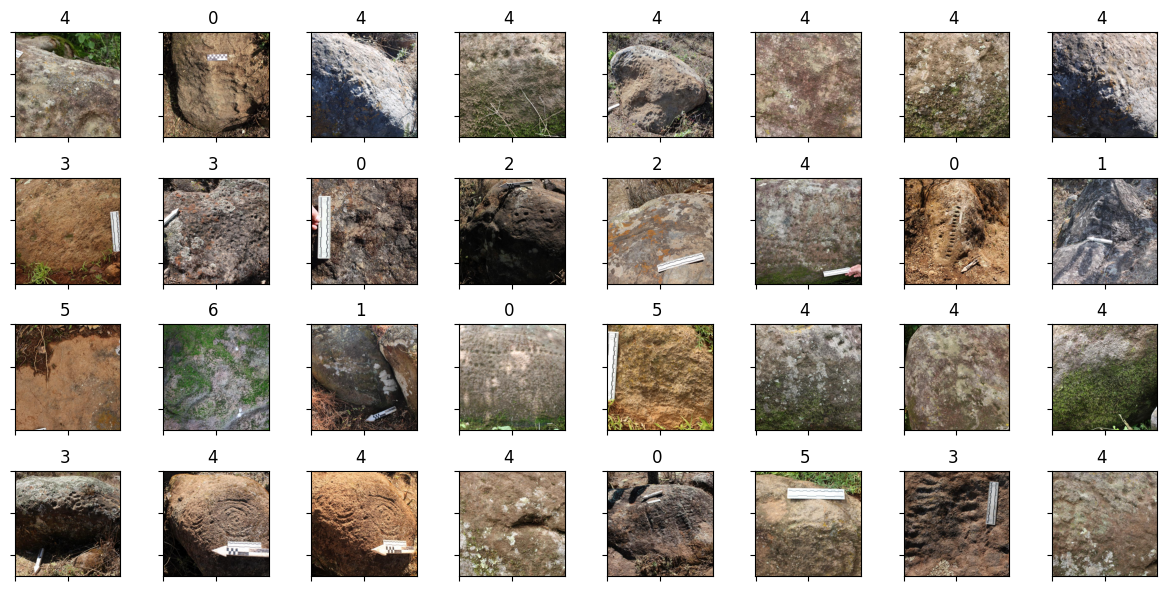

In [11]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
)
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} '  for l in y]
display_batch(x, titles, ROWS, COLS)

In [12]:
for x, y in take(tst_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 3, 500, 500]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


## Modelos
Vamos a usar distintos modelos para el entrenamiento

In [32]:
modelo_alexnet = tvm.alexnet(pretrained=True)
summary(modelo_alexnet, (3, 500, 500), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 64, 124, 124]        23,296
|    └─ReLU: 2-2                         [-1, 64, 124, 124]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 61, 61]          --
|    └─Conv2d: 2-4                       [-1, 192, 61, 61]         307,392
|    └─ReLU: 2-5                         [-1, 192, 61, 61]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 30, 30]         --
|    └─Conv2d: 2-7                       [-1, 384, 30, 30]         663,936
|    └─ReLU: 2-8                         [-1, 384, 30, 30]         --
|    └─Conv2d: 2-9                       [-1, 256, 30, 30]         884,992
|    └─ReLU: 2-10                        [-1, 256, 30, 30]         --
|    └─Conv2d: 2-11                      [-1, 256, 30, 30]         590,080
|    └─ReLU: 2-12                        [-1, 256, 30, 30]   

# Código del Paper

In [33]:
class EstimatorCV():
    def __init__(self, feature_num, class_num):
        super(EstimatorCV, self).__init__()
        self.class_num = class_num
        self.CoVariance = torch.zeros(class_num, feature_num, feature_num).cuda()
        self.Ave = torch.zeros(class_num, feature_num).cuda()
        self.Amount = torch.zeros(class_num).cuda()

    def update_CV(self, features, labels):
        N = features.size(0)
        C = self.class_num
        A = features.size(1)

        NxCxFeatures = features.view(
            N, 1, A
        ).expand(
            N, C, A
        )
        onehot = torch.zeros(N, C).cuda()
        onehot.scatter_(1, labels.view(-1, 1), 1)

        NxCxA_onehot = onehot.view(N, C, 1).expand(N, C, A)

        features_by_sort = NxCxFeatures.mul(NxCxA_onehot)

        Amount_CxA = NxCxA_onehot.sum(0)
        Amount_CxA[Amount_CxA == 0] = 1

        ave_CxA = features_by_sort.sum(0) / Amount_CxA

        var_temp = features_by_sort - \
                   ave_CxA.expand(N, C, A).mul(NxCxA_onehot)

        var_temp = torch.bmm(
            var_temp.permute(1, 2, 0),
            var_temp.permute(1, 0, 2)
        ).div(Amount_CxA.view(C, A, 1).expand(C, A, A))

        sum_weight_CV = onehot.sum(0).view(C, 1, 1).expand(C, A, A)

        sum_weight_AV = onehot.sum(0).view(C, 1).expand(C, A)

        weight_CV = sum_weight_CV.div(
            sum_weight_CV + self.Amount.view(C, 1, 1).expand(C, A, A)
        )
        weight_CV[weight_CV != weight_CV] = 0

        weight_AV = sum_weight_AV.div(
            sum_weight_AV + self.Amount.view(C, 1).expand(C, A)
        )
        weight_AV[weight_AV != weight_AV] = 0

        additional_CV = weight_CV.mul(1 - weight_CV).mul(
            torch.bmm(
                (self.Ave - ave_CxA).view(C, A, 1),
                (self.Ave - ave_CxA).view(C, 1, A)
            )
        )

        self.CoVariance = (self.CoVariance.mul(1 - weight_CV) + var_temp
                      .mul(weight_CV)).detach() + additional_CV.detach()

        self.Ave = (self.Ave.mul(1 - weight_AV) + ave_CxA.mul(weight_AV)).detach()

        self.Amount += onehot.sum(0)


class ISDALoss(nn.Module):
    def __init__(self, feature_num, class_num):
        super(ISDALoss, self).__init__()

        self.estimator = EstimatorCV(feature_num, class_num)

        self.class_num = class_num

        self.cross_entropy = nn.CrossEntropyLoss()

    def isda_aug(self, fc, features, y, labels, cv_matrix, ratio):

        N = features.size(0)
        C = self.class_num
        A = features.size(1)

        weight_m = list(fc.parameters())[0]

        NxW_ij = weight_m.expand(N, C, A)

        NxW_kj = torch.gather(NxW_ij,
                              1,
                              labels.view(N, 1, 1)
                              .expand(N, C, A))

        CV_temp = cv_matrix[labels]

        # sigma2 = ratio * \
        #          torch.bmm(torch.bmm(NxW_ij - NxW_kj,
        #                              CV_temp).view(N * C, 1, A),
        #                    (NxW_ij - NxW_kj).view(N * C, A, 1)).view(N, C)

        sigma2 = ratio * \
                 torch.bmm(torch.bmm(NxW_ij - NxW_kj,
                                     CV_temp),
                           (NxW_ij - NxW_kj).permute(0, 2, 1))

        sigma2 = sigma2.mul(torch.eye(C).cuda()
                            .expand(N, C, C)).sum(2).view(N, C)

        aug_result = y + 0.5 * sigma2

        return aug_result

    def forward(self, model, fc, x, target_x, ratio):

        features = model(x)

        y = fc(features)

        self.estimator.update_CV(features.detach(), target_x)

        isda_aug_y = self.isda_aug(fc, features, y, target_x, self.estimator.CoVariance.detach(), ratio)

        loss = self.cross_entropy(isda_aug_y, target_x)

        return loss, y

Creo manualmente la última capa de AlexNet que después la adjuntaré.

In [38]:
class Full_layer(torch.nn.Module):
    '''explicitly define the full connected layer'''

    def __init__(self, feature_num, class_num):
        self.feature_num = 1024
        self.class_num = 7
        super(Full_layer, self).__init__()
        self.class_num = class_num
        self.fc = nn.Linear(feature_num, class_num)

    def forward(self, x):
        x = self.fc(x)
        return x

fc = Full_layer(1024, 7)
summary(fc)
fc.feature_num

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            7,175
Total params: 7,175
Trainable params: 7,175
Non-trainable params: 0


1024

In [36]:
#Updating the second classifier
modelo_alexnet.classifier[4] = nn.Linear(4096,1024)
modelo_alexnet.classifier[6] = fc
summary(modelo_alexnet, (3, 500, 500), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 64, 124, 124]        23,296
|    └─ReLU: 2-2                         [-1, 64, 124, 124]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 61, 61]          --
|    └─Conv2d: 2-4                       [-1, 192, 61, 61]         307,392
|    └─ReLU: 2-5                         [-1, 192, 61, 61]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 30, 30]         --
|    └─Conv2d: 2-7                       [-1, 384, 30, 30]         663,936
|    └─ReLU: 2-8                         [-1, 384, 30, 30]         --
|    └─Conv2d: 2-9                       [-1, 256, 30, 30]         884,992
|    └─ReLU: 2-10                        [-1, 256, 30, 30]         --
|    └─Conv2d: 2-11                      [-1, 256, 30, 30]         590,080
|    └─ReLU: 2-12                        [-1, 256, 30, 30]   

In [51]:
print(modelo_alexnet.classifier[6].feature_num)
#optimizer = optim.SGD([{'params': modelo_alexnet.parameters()},
 #                            {'params': modelo_alexnet.classifier[6].parameters()}],......)
isda_criterion = ISDALoss(modelo_alexnet.classifier[6].feature_num, 7).cuda()


1024


In [55]:
modelo = torch.nn.DataParallel(modelo_alexnet).cuda()


In [58]:
summary(modelo_alexnet, (3, 500, 500), device='cpu', verbose=0)
summary(isda_criterion)

Layer (type:depth-idx)                   Param #
├─CrossEntropyLoss: 1-1                  --
Total params: 0
Trainable params: 0
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─CrossEntropyLoss: 1-1                  --
Total params: 0
Trainable params: 0
Non-trainable params: 0

## Entrenamiento

In [69]:
# obtenemos dispositivo en gpu, si no en cpu
#device = torch.device('cpu')
#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [63]:
def train_epoch(data_loader,model,fc, criterion, opt,epoch):
  # para cada lote
  for x, y_true in data_loader:
    x = x.to(device)
    #y_true = y_true.flatten()
    
    #y_true = y_true.type(torch.LongTensor)
    y_true = y_true.to(device)
    #print(y_true)  
    #y_true = y_true.to(device)
    # inferencia
    #print(y_true.type())
    y_lgts = model(x)
    #print(y_lgts.size())
    y_prob = F.softmax(y_lgts, 1)
    #print(y_prob.size())
    y_hat = torch.argmax(y_prob, 1)
    #loss = F.cross_entropy(y_lgts, y_true)
    # backprop
    loss, output = criterion(model, fc, y_true, y_lgts, 10)
    opt.zero_grad() # vaciamos los gradientes
    loss.backward() # retropropagamos
    opt.step() # actualizamos parámetros

def eval_epoch(data_loader, model, epoch):
  # Para la evaluación evitamos que se regsitren las operaciones
  with torch.no_grad():
    
    losses = []
    accs= []
    for x, y_true in data_loader:
      x = x.to(device)
      y_true = y_true.to(device)
      y_lgts = model(x) # Evaluamos
      y_prob = F.softmax(y_lgts, 1)
      y_hat = torch.argmax(y_prob, 1)
      loss_b = F.cross_entropy(y_lgts, y_true) # Calculamos la pérdida
      acc = (y_true == y_hat).type(torch.float32).mean()
      losses.append(loss_b.item())
      accs.append(acc.item() * 100)
    
    loss = np.mean(losses)
    acc = np.mean(accs)
    return loss, acc

def train(model, train_dl, test_dl,epochs=10,lr=1e-3,opt='Adam',
          transfer_learning = False,full_train=False,
          L2lambda=0,progress=True):
  
  model = model.to(device)
  loss_hist = []
  acc_hist= []
  # optimizadores
  if opt == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=L2lambda)
  if opt == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=L2lambda)
  if opt == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=L2lambda)

  # Congelamos loss parámetros
  #if transfer_learning:
  #  freeze = not full_train # si no se quiere reentrenar toda la red, se congelan los parametros
  #  model.freeze_features(freeze)

  # Para imprimir el progreso
  range_progress = trange(epochs)  if progress else range(epochs)

  model.eval()

  # ciclo de entrenamiento
  for epoch in range_progress:
    # Entrenamiento
    model.train()
    train_epoch(train_dl,model,optimizer,epoch)

    # Evaluación
    model.eval()
    train_loss, train_acc = eval_epoch(train_dl, model, epoch)
    test_loss, test_acc = eval_epoch(test_dl, model, epoch)
  
    loss_hist.append([train_loss,test_loss])
    acc_hist.append([train_acc,test_acc])
    if progress:
      print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}]'f'acc=[{train_acc:6.2f},{test_acc:6.2f}]')
      
  return loss_hist, acc_hist

In [62]:
loss1, acc1= train(ISDALoss, trn_dl, tst_dl,epochs=30,lr=1e-4,opt='Adam',
          transfer_learning = True,progress=True)


AttributeError: 'torch.device' object has no attribute '_apply'

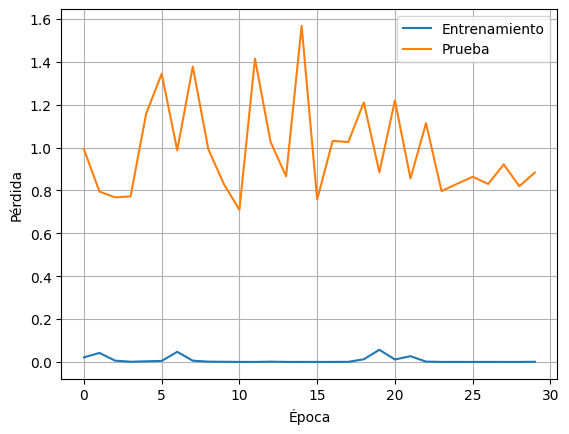

In [ ]:
display_losses(loss1)

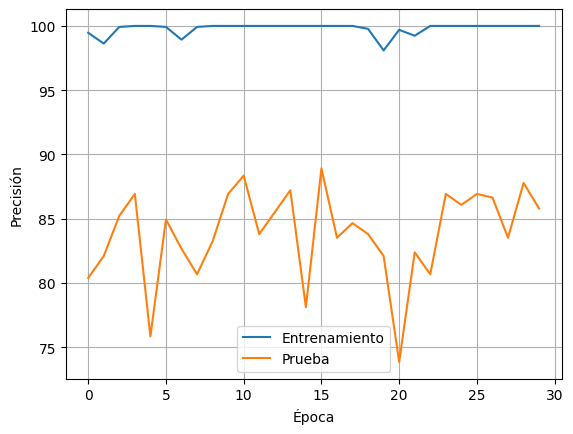

In [ ]:
display_acc(acc1)